# Проект: Принятие решений в бизнесе

# Цель исследования:
Аналитик крупного интернет-магазина вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.\
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты работы. 

# Описание данных:

**Данные для первой части:**
Файл /datasets/hypothesis.csv содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.\
-Hypothesis — краткое описание гипотезы;\
-Reach — охват пользователей по 10-балльной шкале;\
-Impact — влияние на пользователей по 10-балльной шкале;\
-Confidence — уверенность в гипотезе по 10-балльной шкале;\
-Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.\

**Данные для второй части:**
Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.
Файл /datasets/orders.csv и файл /datasets/visitors.csv содержат описание результатов А/В-теста.\

    *Файл /datasets/orders.csv
-transactionId — идентификатор заказа;\
-visitorId — идентификатор пользователя, совершившего заказ;\
-date — дата, когда был совершён заказ;\
-revenue — выручка заказа;\
-group — группа A/B-теста, в которую попал заказ.\

    *Файл /datasets/visitors.csv
-date — дата;\
-group — группа A/B-теста;\
-visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# План работы:

## Загрузка данных:

In [1]:
## Загрузим все необходимые библиотеки:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
import datetime as dt
import math as mth


In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
# Чтобы увидеть полное название гипотез:
pd.set_option('max_colwidth', 800)

In [4]:
hypothesis.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
hypothesis.duplicated().sum()

0

В таблице hypothesis типы данных соответствуют содержимому столбцов. Пропуски и дубликаты отсутствуют.

In [7]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders.duplicated().sum()

0

In [10]:
orders["date"] = orders["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

В таблице orders не все типы данных соответствуют содержимому. Заменили тип данных в столбце ['date'] object  на datetime. Пропуски и дубликаты отсутствуют.

In [11]:
group_a=orders.query('group == "A"') 
group_b=orders.query('group == "B"') 
  
# получаем id пользователей, попавших в обе группы 
ab_group=list(np.intersect1d(group_a['visitorId'], group_b['visitorId']))
len(ab_group)

58

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


В таблице оказалось 58 пользователей, которые попали в группы А и В одновременно. Это 4.8% от общих данных - это достаточно много. Мы не имеем возможности уточнить, к какой конкретно группе относятся пользователи, которые попали в обе группы. Скорее всего, та же ситуация произошла с таблицей visitors, но данные в ней агрегированные и мы не можем это проверить. Такие данные можно удалить только из таблицы orders, из таблицы visitors удалить не можем. Поэтому оставляем всё так, как есть.

In [13]:
group_a=orders.query('group == "A"') 
group_b=orders.query('group == "B"') 
  
# получаем id пользователей, попавших в обе группы 
ab_group=list(np.intersect1d(group_a['visitorId'], group_b['visitorId']))
len(ab_group)

58

In [14]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [16]:
visitors.duplicated().sum()

0

In [17]:
# заменим тип данных visitors['date'] object->datetime
visitors["date"] = visitors["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

В таблице visitors не все типы данных соответствуют содержимому. Заменили тип данных в столбце ['date'] object  на datetime. Пропуски и дубликаты отсутствуют.

**Выводы:**
Мы успешно импортировали необходимые библиотеки для дальнейшей работы над проектом, произвели загрузку данных,ознакомились с содержимым каждого из файлов, привели типы данных столбцов в соответствии с их содержимым. Пропусков в данных не обнаружено.
Данные из всех трех таблиц готовы для дальнейшей работы. 

## Приоритизация гипотез.
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

### Необходимо применить фреймворк ICE для приоритизации гипотез и отсортировать их по убыванию приоритета. 

**ICE Score = Impact * Confidence / Efforts**


In [18]:
hypothesis['ICE'] = hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']

-Hypothesis — краткое описание гипотезы;\
-Reach — охват пользователей по 10-балльной шкале;\
-Impact — влияние на пользователей по 10-балльной шкале;\
-Confidence — уверенность в гипотезе по 10-балльной шкале;\
-Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 

In [19]:
display(hypothesis[['Hypothesis','ICE']].sort_values(by = 'ICE', ascending = False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы по ICE: 

8 - Запустить акцию, дающую скидку на товар в день рождения\
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей\
7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок 

### Необходимо применить фреймворк RICE для приоритизации гипотез и отсортировать их по убыванию приоритета. Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

**RICE Score = Reach * Impact * Confidence / Efforts**

In [20]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [21]:
display(hypothesis[['Hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Сравнивая результаты, полученные в ходе подсчетов ICE и RICE, мы можем заметить, что рейтинг перспективности гипотез изменился:
Как и в случае с ICE, в число наиболее перспективных гипотез вошли:\
7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок\
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей\
Однако, к ним добавилась гипотеза:\
2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
Это произошло из-за того, что RICE при подсчете перспективности, в отличие от ICE учитвает параметр "Reach"(охват пользователей по 10-балльной шкале)
Гипотеза №7 стала наиболее приоритетной благодаря максимальному охвату пользователей
Гипотеза №8 (скидка на товар в день рождения) вышла из  тройки лидеров, т.к. предположительно, не все пользователи указывают дату своего рождения при использовании сервиса.

## Анализ A/B-теста
Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.
Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [22]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [23]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Соберём агрегированные кумулятивные по дням данные о заказах:

In [24]:
# создаем массив уникальных пар значений дат и групп теста:
datesGroups = orders[['date', 'group']].drop_duplicates()
# получаем агрегированные кумулятивные по дням данные о заказах:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max',
      'group' : 'max', 
      'visitorId' : 'nunique', 
      'transactionId' : 'nunique', 
      'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [25]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 
                                             'group' : 'max', 
                                             'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [26]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'buyers', 'orders',  'revenue', 'visitors']

In [27]:
cumulativeData.head(5)

,date,group,buyers,orders,revenue,visitors
0,2019-08-01,A,20,24,148579,719
1,2019-08-01,B,20,21,101217,713
2,2019-08-02,A,38,44,242401,1338
3,2019-08-02,B,43,45,266748,1294
4,2019-08-03,A,62,68,354874,1845


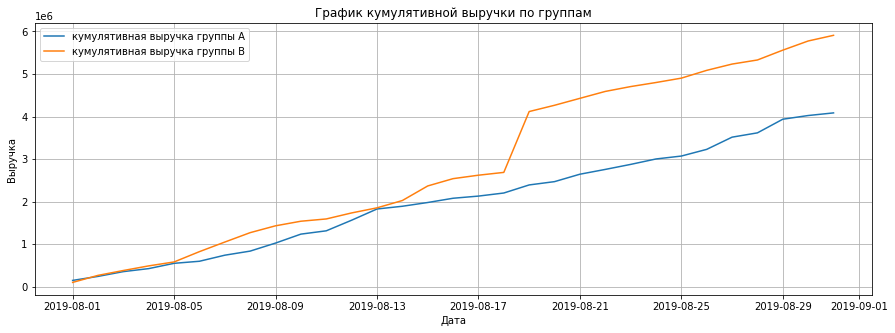

In [28]:
#Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15, 5))
plt.grid()
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='кумулятивная выручка группы A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='кумулятивная выручка группы B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();


Выручка увеличивается равномерно на протяжении всего теста, за исключением резкого скачка за период между 2019-08-17 и 2019-08-21 в группе В. Этом может сигнализировать о наличии выбросов (всплеск числа заказов, либо аномально дорогие заказы в выборке) 

In [29]:
# изучим выручки в группе В за период между 2019-08-17 и 2019-08-21.
cumulativeRevenueB.query(' "2019-08-17" <= date <= "2019-08-21" ')

,date,revenue,orders
33,2019-08-17,2620790,373
35,2019-08-18,2686621,382
37,2019-08-19,4116541,403
39,2019-08-20,4263815,423
41,2019-08-21,4426892,437


Видим, что скачок выручки произошел 19 августа. Далее, посмотрим на заказы в этот день:

In [30]:
orders.query(' date == "2019-08-19" ').sort_values(by='revenue', ascending=False).head(8)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A
461,2683113224,154576532,2019-08-19,26550,B
525,3031564664,393266494,2019-08-19,21550,A
368,3268879337,2536252163,2019-08-19,20026,B
366,2037051350,1957949546,2019-08-19,16770,A


Нашли огромный аномальный заказ на 1 294 500 - почти 1,3 млн!
Далее от него нужно будет избавиться.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

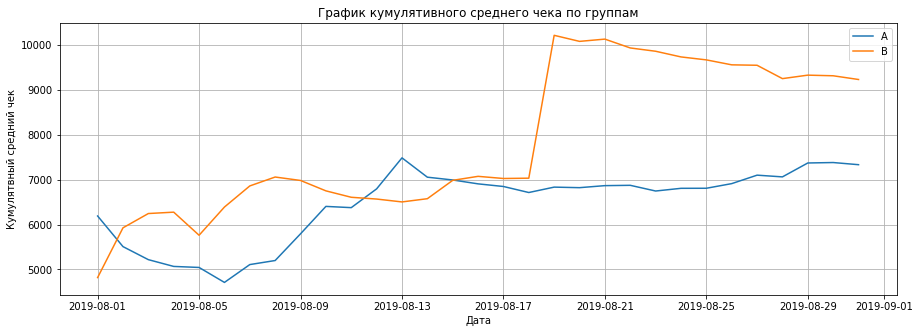

In [31]:
#Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label = 'B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятвный средний чек')
plt.legend();

Возможно, в группу B во второй половине теста попали крупные заказы (наблюдаем резкий всплеск значений на графике во второй половине теста). 
В группе А наблюдаем падение среднего чека после начала теста, затем рост. Во второй половине теста значения среднего чека для группы А стабилизируются, а в группе В постепенно падают.

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

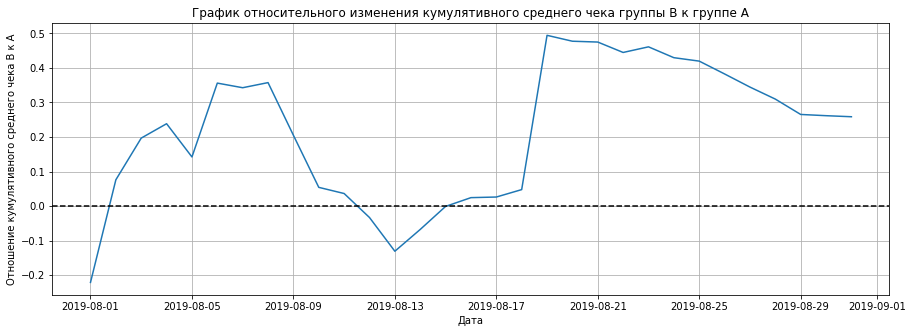

In [32]:
#Построим график относительного различия для среднего чека. 
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивного среднего чека В к А');

Средний чек группы В непрерывно рос до 4 августа, затем 5 августа мы наблюдаем краткосрочное падение показателей, за которым, далее следует рост вплоть до 8 августа.
13 августа средний чек группы В достиг минимума и опустился ниже значений группы А.
Первый пик графика  связан с флуктуацией данных.
19 августа был совершен крупный заказ, который вывел группу В в лидеры. Далее, мы наблюдаем как средний чек группы В постепенно снижается со временем.
Второй пик графика связан с аномальным всплеском группы В.

### Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

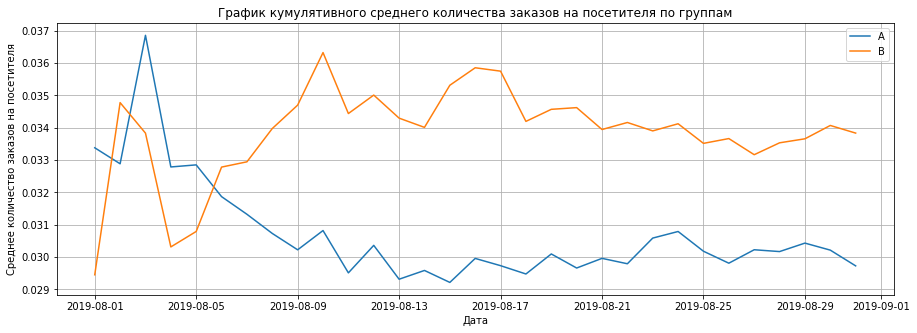

In [33]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя');

# задаем масштаб осей
#plt.axis(["2019-04-01", '2019-04-23', 0, 0.015]) 

Первую неделю теста значения конверсии по группам значительно колеблются. Показатели группы В выше, чем группы А. Затем данные меняются и группа В значительно лидирует по среднему количеству заказов на посетителя, по сравнению с группой А.
Во второй половине проведения теста показатели обеих групп значительно стабилизировались.

### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.


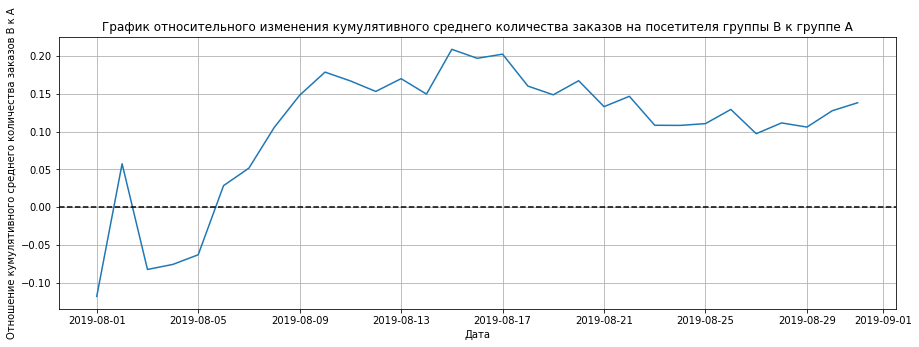

In [34]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивного среднего количества заказов В к А');

Относительное изменение кумулятивного среднего количества заказов на посетителя группы В к группе А растет неравномерно. В первую неделю проведения теста мы наблюдаем особенно резкие скачки показателя. В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд с устойчивым результатом, начиная с 6 августа. 
К середине периода (17 августа) заметно снижение роста и выход на плато.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.


In [35]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


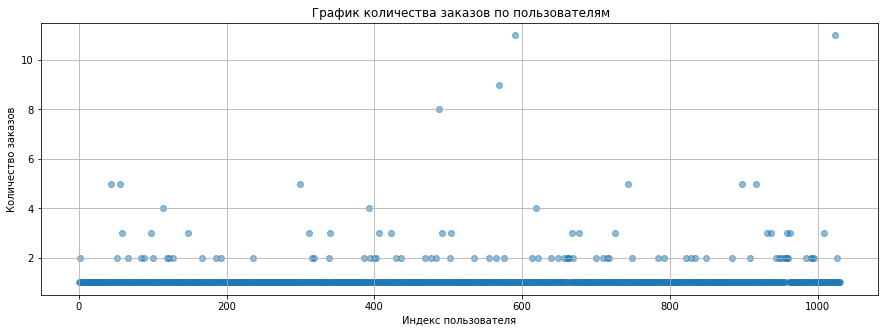

In [36]:
orders_agg = (
    orders
    .groupby(by=['visitorId'])
    .agg({'transactionId': 'count'})
    .rename(columns={'transactionId': 'orders_cnt'})
    .reset_index()
)
plt.figure(figsize=(15, 5))

x_values = pd.Series(range(0, len(orders_agg['orders_cnt'])))
plt.scatter(x_values, orders_agg['orders_cnt'], alpha = 0.5)

plt.title(' График количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Индекс пользователя')
plt.grid()


Как мы и предполагали ранее, в данных имеются аномалии - несколько пользователей с большим количеством заказов. Некоторые из них совершили 8, 9 и даже 11 заказов. 
По графику можем определить границу аномально большого количества заказов: между 3 и 4. Однако, принято отсеивать  от 1% до 5% наблюдений с крайними значениями, поэтому произведем дальнейшие расчеты:

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.


In [37]:
print(np.percentile(orders_agg['orders_cnt'], [95, 96, 97, 98, 99]))

[2. 2. 2. 3. 4.]


Назначим границу для определения аномальных пользователей:
Если пользователь совершил более двух заказов, то будем считать такой случай за аномальный. 
Так мы отсечем не более 5% от всех данных.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.


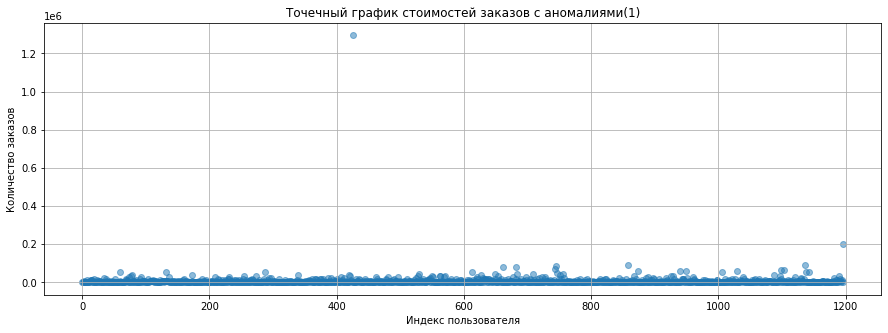

In [38]:
x1_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 5))
plt.grid()
plt.scatter(x1_values, orders['revenue'], alpha = 0.5)
plt.title('Точечный график стоимостей заказов с аномалиями(1)')
plt.ylabel('Количество заказов')
plt.xlabel('Индекс пользователя');

На графике заметно экстремальное значение стоимости заказа, превышающее 1,2 млн и еще одно, на 200 тыс., в то время как основная масса стоимости заказов не превышает 100 тыс. Этот выброс мог оказаться решающим в успешности показателей группы В. Для того, чтобы изучить более реальные данные, необходимо избавиться от выбросов. в качестве границы отсечения экстремальных данных стоимости заказа возьмем значение 100 тыс.

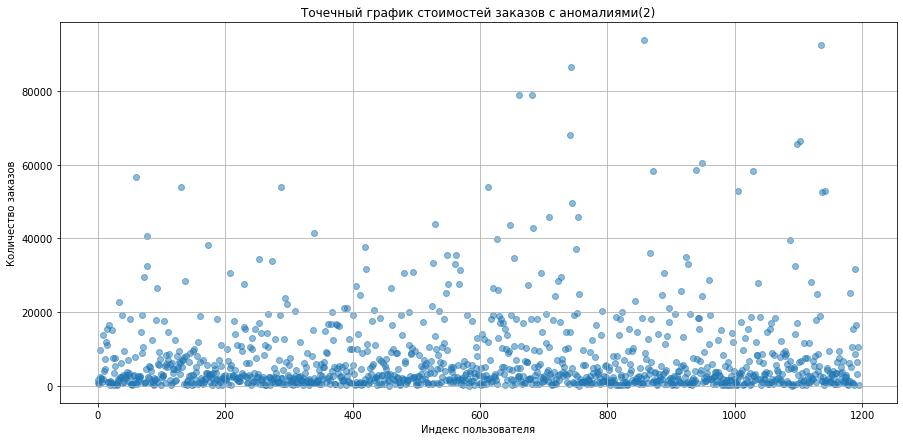

In [39]:
new_orders = orders[orders['revenue']<=100000]['revenue']
x2_values = pd.Series(range(0, len(new_orders)))
plt.figure(figsize=(15, 7))
plt.grid()
plt.scatter(x2_values, new_orders, alpha = 0.5)
plt.title('Точечный график стоимостей заказов с аномалиями(2)')
plt.ylabel('Количество заказов')
plt.xlabel('Индекс пользователя');

Теперь, в отсутствии выбросов, график выглядит совершенно иначе. Больше всего заказов  до 20 тыс. Стоимость выше 60 тысяч мы наблюдаем только у одиночных редких заказов.
Можем отбросить суммарно до 5% аномальных данных, для этого необходимо  расчитать перцентили стоимости заказов

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.


In [40]:
print(np.percentile(orders['revenue'], [95, 96, 97, 98, 99]))

[28000.  31382.  35485.  44133.2 58233.2]


Возьмем за границу для определения стоимости аномальных заказов значение 50 тыс - так мы избавимся приблизительно % данных.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.


In [41]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [42]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [43]:
#visitorsA
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
#visitorsB
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
#OrdersA
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]
#OrdersB
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Названия столбцов данных:

date — дата;\
ordersPerDateA — количество заказов в выбранную дату в группе A;\
revenuePerDateA — суммарная выручка в выбранную дату в группе A;\
ordersPerDateB — количество заказов в выбранную дату в группе B;\
revenuePerDateB — суммарная выручка в выбранную дату в группе B;\
ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;\
revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;\
ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;\
revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;\
visitorsPerDateA — количество пользователей в выбранную дату в группе A;\
visitorsPerDateB — количество пользователей в выбранную дату в группе B;\
visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;\
visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.\
Посчитаем статистическую значимость различия в среднем количестве заказов между группами.

In [44]:
#Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns =  ['visitorId', 'orders']


In [45]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [46]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


Сформулируем нулевую и альтернативную гипотезы о различии в среднем количестве заказов на посетителя между группами по «сырым» данным:

Н0: Среднее количество заказов на посетителя между группами (по "сырым" данным) не имеет статистически значимых  различий.
Н1: Среднее количество заказов на посетителя между группами (по "сырым" данным) имеет статистически значимое различия.

Уровень значимости α=0.05

Посчитаем статистическую значимость различия среднего количества заказов по результатам теста.\
Применим тест Манна-Уитни. 

In [47]:
# p-value для сравнения среднего между группами
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# относительное различие в среднем между группами
print("Относительный прирост В = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
 

p-value = 0.017
Относительный прирост В = 0.138


p_value=0.017, или 1.7%\
Заданный уровень статистической значимости α=0.05 или 5%\
Следовательно, p_value < α.\
На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть нулевую гипотезу в пользу альтернативной.
Соответственно, можно утверждать, что:\
"Среднее количество заказов на посетителя между группами (по "сырым" данным) имеет статистически значимое различия".\
Относительный прирост группы В по среднему количеству заказов на посетителя составил 13.8%

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.


Сформулируем нулевую и альтернативную гипотезы о различии в среднем чеке заказа между группами по «сырым» данным.\
Н0:Статистически значимых различий в средних чеках между группами нет.\
Н1:Есть статистически значимые различия в средних чеках между группами.

Уровень значимости альфа α=0.05

In [48]:
#p-value для сравнения средних чеков между группами:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
# относительный прирост среднего чека группы B
print('Относительный прирост В = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.729
Относительный прирост В = 0.259


p_value=0.729, или 72.9%
Заданный уровень статистической значимости α=0.05 или 5%\
Следовательно, p_value > α.\
На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) нет оснований для отвержения нулевой гипотезы в пользу альтернативной.\
Соответственно, не получилось отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в средних чеках между группами. Разница между выборками имеет случайный характер.

Относительное различие среднего чека меду сегментами 25.9%


### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.


В таблице abnormalUsers объединим пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 40 000 — usersWithExpensiveOrders.

In [49]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
abnormalUsers.shape[0]

1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
dtype: int64


37

Всего 37 аномальных значений.

Сформулируем нулевую и альтернативную гипотезы о наличии статистически значимых различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.
Н0:Статистически значимых различий в среднем количестве заказов на посетителя между группами нет.
Н1:Есть статистически значимые различия в среднем количестве заказов на посетителя между группами.

Уровень значимости альфа α=0.05

In [50]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [51]:
#p-value для сравнения среднего между очищенными группами.
print('p-value = {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

#относительный прирост среднего очищенной группы B
print('Относительный прирост В = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value = 0.00821
Относительный прирост В = 0.182


p_value=0.008, или 0.8%\
Заданный уровень статистической значимости α=0.05 или 5%\
Следовательно, p_value < α.\
На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть нулевую гипотезу в пользу альтернативной.
Соответственно, можно утверждать, что:\
"Среднее количество заказов на посетителя между группами (по "очищенным" данным) имеет статистически значимое различие".\
Относительный прирост группы В по среднему количеству заказов на посетителя составил 18.2%
Результаты по сравнению среднего (на сырых данных по сравнению с очищенными) значимо не изменились, выводы остаются те же.\
На очищенных данных, по сравнению с сырыми, p_value уменьшился с 1.7% до 0.8% 
Проигрыш группы A на очищенных данных немного увеличился 18.2% против 13.8% на сырых

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.


Сформулируем нулевую и альтернативную гипотезы о различии в среднем чеке заказа между группами по «очищенным» данным.
Н0:Статистически значимых различий в средних чеках между группами нет.
Н1:Есть статистически значимые различия в средних чеках между группами.

Уровень значимости альфа α=0.05

In [52]:
# p-value для сравнения средних чеков между очищенными группами. 
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

#относительный прирост среднего чека очищенной группы B

print(
    "Относительный прирост В = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value = 0.940
Относительный прирост В = 0.019


p_value=0.94, или 94.0% Заданный уровень статистической значимости α=0.05 или 5%
Следовательно, p_value > α.
На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) нет оснований для отвержения нулевой гипотезы в пользу альтернативной.
Соответственно, не получилось отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в средних чеках между группами. Разница между выборками имеет случайный характер.

На очищенных данных, по сравнению с сырыми, p_value увеличился с 72.9% до 94.0% Проигрыш группы A на очищенных данных уменьшился 1.9% против 25.9% на сырых

### Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

По графикам:\
Кумулятивная выручка росла равномерно в течение всего рассматриваемого периода в группе А, в группе В наблюдали скачок за период между 2019-08-17 и 2019-08-21.\
График кумулятивного среднего чека по группам и  точечный график стоимостей заказов позволил нам обнаружить аномалии в данных. Позже, при помощи точечного графика стоимостей заказов мы окончательно убедились в их наличии.
график кумулятивного среднего количества заказов на посетителя по группам сообщает, что результаты группы B лучше группы A после первой недели теста.

**Посчитали статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» и «очищенным» данным:**

Аномалии особо не повлияли на статистическую значимость. 
Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым» и по "обработанным" даннымю По очищенным данным p_value уменьшился с 1.7% до 0.8%
Относительный прирост группы В к группе А увеличился с 13.8% до 18.2%

**Посчитали статистическую значимость различий в среднем чеке заказа между группами по  «сырым» и «очищенным» данным:**

Статистической разницы по среднему чеку между группами ни по "очищенным" ни по "сырым" данным нет. p_value увеличился с 72.9% до 94.0%
Относительный прирост группы В к группе А уменьшился с 25.9% до 1.9% - на данном показателе больше всего сказалось влияние аномальных данных.

Исходя из вышеперечисленных причин, тест следует остановить и признать успешным.
Признаем победу группы В по среднему количеству заказов на посетителя, при том, что по среднему чеку группы А И В не имеют различий.